<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/predictive_maintanence_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from array import array
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


# Arima

In [5]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 5.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/temp_arima.pkl', 'rb')
temp_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/vibx_arima.pkl', 'rb')
vibx_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/vibz_arima.pkl', 'rb')
vibz_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/zacc_arima.pkl', 'rb')
zacc_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/crest_arima.pkl', 'rb')
crest_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/zfreq_arima.pkl', 'rb')
zfreq_arima_model = pickle.load(pickle_in)

In [7]:
df_arima = pd.DataFrame()
arima_models= [vibx_arima_model,vibz_arima_model,temp_arima_model,zacc_arima_model,crest_arima_model,zfreq_arima_model]
columns=["vibx","vibz","temp","zacc","crest","zfreq"]
for model,col in zip(arima_models,columns):
    df_arima['arima_predicted_'+col]=model.predict(start=df.index[0],end=df.index[-1])
    df_arima[col]=df[col]


TypeError: ignored

In [8]:
df_arima.head()

""


# LSTM univariate prediction

In [9]:
# convert an array of values into a dataset matrix
df_lstm_univarete = pd.DataFrame()
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
 def test_lstm_univariate(df,col):
    pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl", 'rb')
    scaler_lstm_univarate = pickle.load(pickle_in)
    df1=scaler_lstm_univarate.transform(np.array(df.loc[:,col]).reshape(-1,1))
    model_lstm_univarate=load_model(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_lstm_univariate_model.h5")
    X_test, ytest = create_dataset(df1, time_step=3)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    test_predict=model_lstm_univarate.predict(X_test)
    test_predict=scaler_lstm_univarate.inverse_transform(test_predict)
    return test_predict

In [11]:
test_lstm_predict={}
for col in df.columns[1:7]:
  test_lstm_predict[col]=test_lstm_univariate(df,col)


In [12]:
for col in df.columns[1:7]:
  df_lstm_univarete[col+"lstm_predicted"]= [float(i) for i in test_lstm_predict[col]]

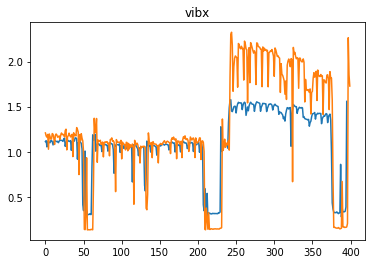

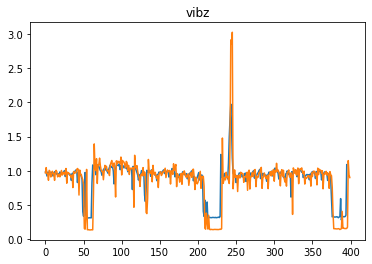

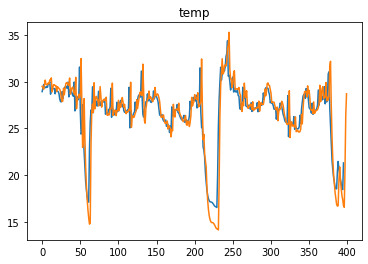

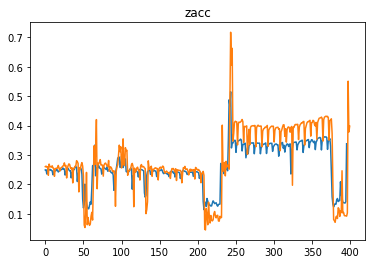

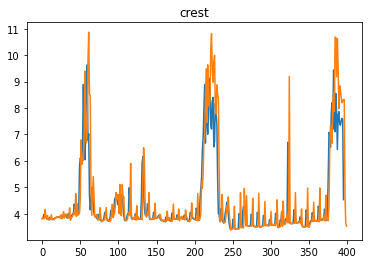

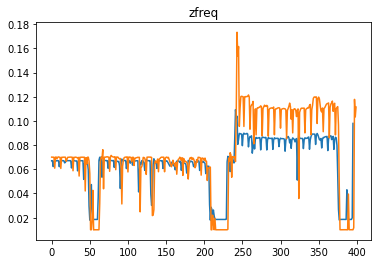

In [14]:
for col in df.columns[1:]:
  plt.plot(df_lstm_univarete[col+"lstm_predicted"])
  plt.plot(df[col])
  plt.title(col)
  plt.show()

# Lstm multivariate

In [15]:
data=df.copy()

In [16]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [17]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)



In [18]:
for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

In [19]:
df_columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'crest', 'zfreq', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Month_2', 'Day of Week_1',
       'Day of Week_2', 'Day of Week_3', 'Day of Week_4', 'Day of Week_5',
       'Day of Week_6', 'lag_1vibx', 'lag_2vibx', 'lag_3vibx', 'lag_1vibz',
       'lag_2vibz', 'lag_3vibz', 'lag_1temp', 'lag_2temp', 'lag_3temp',
       'lag_1zacc', 'lag_2zacc', 'lag_3zacc', 'lag_1crest', 'lag_2crest',
       'lag_3crest', 'lag_1zfreq', 'lag_2zfreq', 'lag_3zfreq',
       'vibxexpanding_mean', 'vibxexpanding_std', 'vibzexpanding_mean',
       'vibzexpanding_std', 'tempexpanding_mean', 'tempexpanding_std',
       'zaccexpanding_mean', 'zaccexpanding_std', 'crestexpanding_mean',
       'crestexpanding_std', 'zfreqexpanding_mean', 'zfreqexpanding_std']

In [20]:
for col in df_columns:
  if col not in df.columns:
    df[col]=[0 for i in df.index]

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
df_lstm_multivariate={}

In [22]:
def lstm_multivariate(df,col_num):
  
  values = df.iloc[:,1:].values

  # ensure all data is float
  values = values.astype('float32')
  # normalize features


  pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}_scaler_lstm_multivariate.pkl", 'rb')
  scaler_lstm_multivariate = pickle.load(pickle_in)
  scaled = scaler_lstm_multivariate.transform(values)
  # specify the number of lag hours
  n_hours = 10
  n_features = df.iloc[:,1:].shape[1]
  # frame as supervised learning
  reframed = series_to_supervised(scaled, n_hours, 1)
  #print(reframed.shape)
      
  # split into train and test sets
  values = reframed.values
  n_train_hours = fail_time-96
      
  test = values
  # split into input and outputs
  n_obs = n_hours * n_features
      
  test_X, test_y = test[:, :n_obs], test[:, col_num]
  #print(train_X.shape, len(train_X), train_y.shape)
  # reshape input to be 3D [samples, timesteps, features]
  test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
  # design network
  # make a prediction
  model_lstm_multivariate=load_model(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}multivariateLSTM_model.h5")
  yhat = model_lstm_multivariate.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
  # invert scaling for forecast
  inv_yhat1 = np.repeat(yhat, df.shape[1]-1, axis=-1)
  inv_yhat1 = scaler_lstm_multivariate.inverse_transform(inv_yhat1)
  inv_yhat1 = inv_yhat1[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.repeat(test_y, df.shape[1]-1, axis=-1)
  inv_y = scaler_lstm_multivariate.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  
  # calculate RMSE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
  print('Test RMSE: %.3f' % rmse)
  pyplot.figure(figsize=(12, 8), dpi=80)
  pyplot.plot(inv_y,label=df.columns[col_num+1])
  pyplot.plot(inv_yhat1,label=df.columns[col_num+1]+"_predicted")
  pyplot.title(df.columns[col_num+1]+" multivariate LSTM")
  pyplot.legend()
  pyplot.show()
  return inv_yhat1

Test RMSE: 0.574


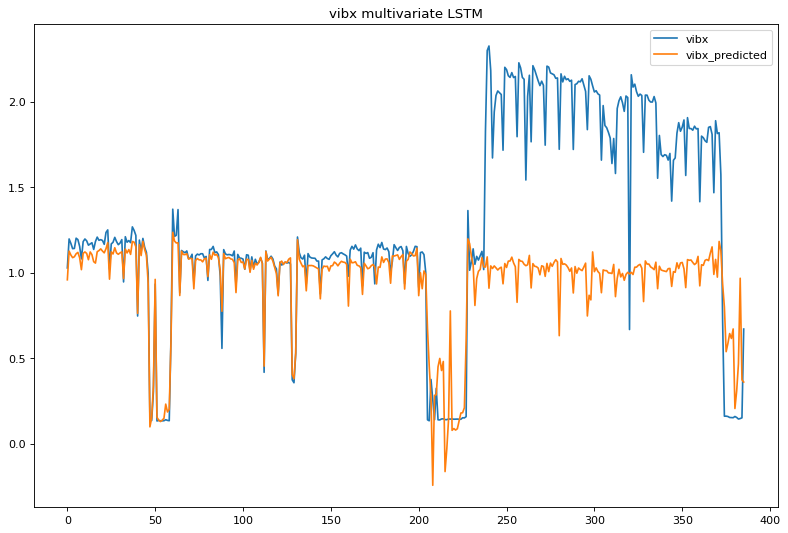

Test RMSE: 0.167


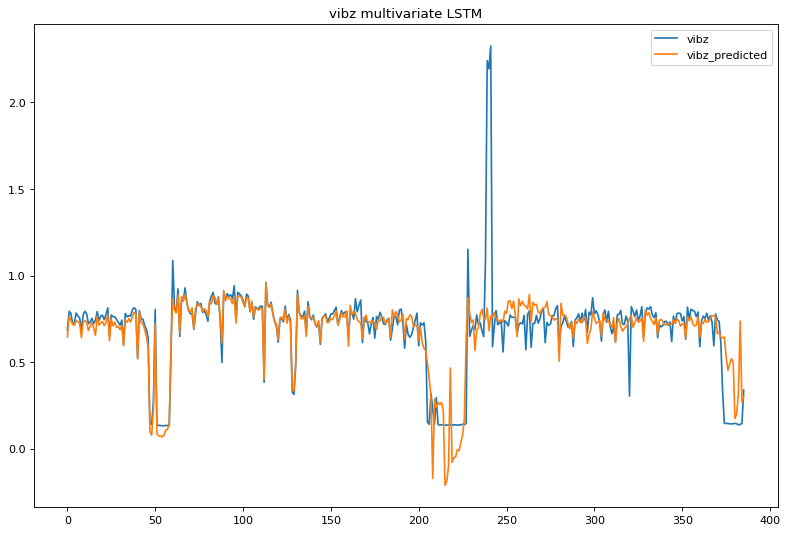

Test RMSE: 0.234


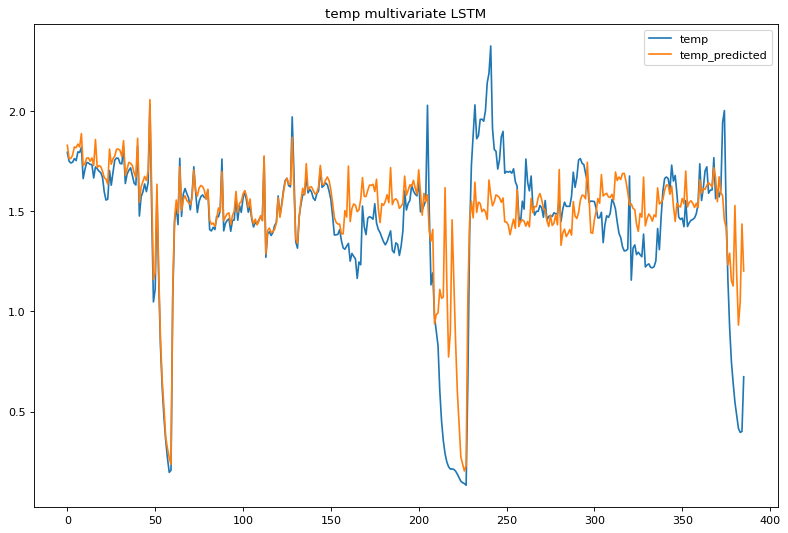

Test RMSE: 0.329


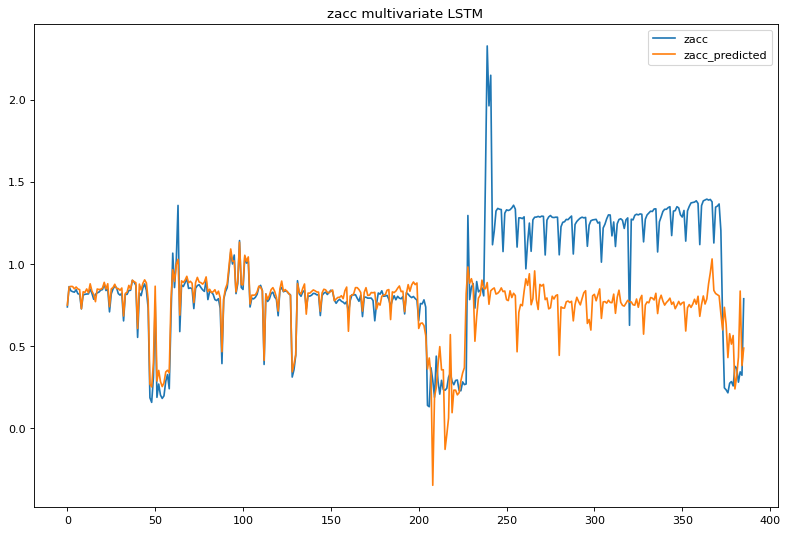

Test RMSE: 0.250


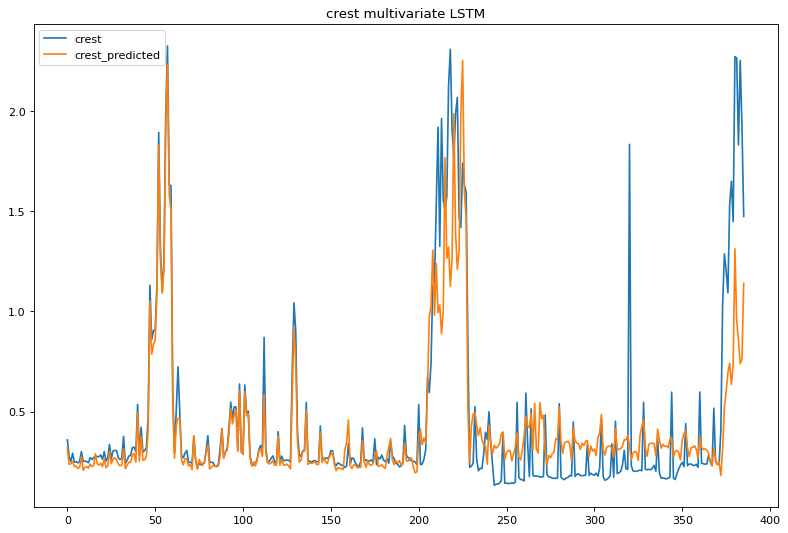

Test RMSE: 0.393


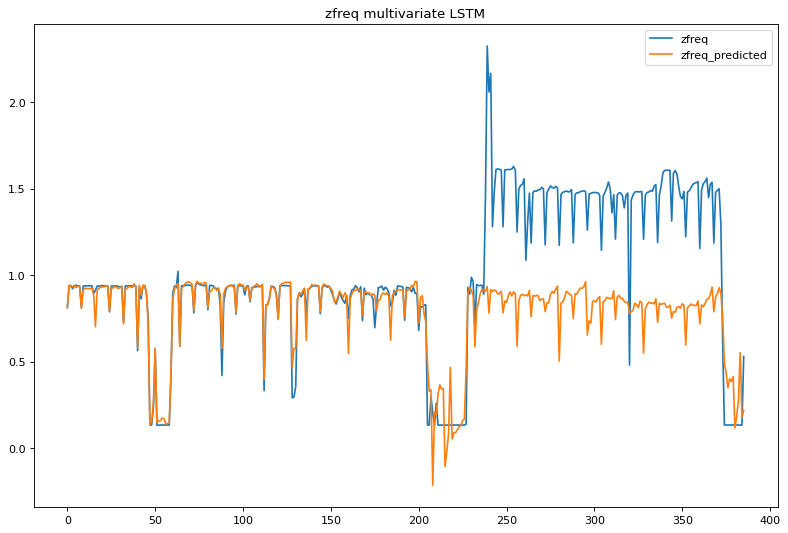

In [23]:
test_lstm_multivariate_predict_df=pd.DataFrame()
for i in range(0,6):
    test_lstm_multivariate_predict_df[df.columns[i+1]]=lstm_multivariate(df=df,col_num=i)


In [24]:
test_lstm_multivariate_predict_df

,vibx,vibz,temp,zacc,crest,zfreq
0,0.957972,0.645476,1.829894,0.750227,0.318392,0.810717
1,1.125625,0.761514,1.763468,0.859571,0.236661,0.941491
2,1.103021,0.743666,1.764104,0.863873,0.239481,0.936817
3,1.087458,0.717659,1.780899,0.863063,0.251227,0.933213
4,1.092649,0.712034,1.821756,0.848720,0.225594,0.940998
...,...,...,...,...,...,...
381,0.307913,0.201252,1.187113,0.315947,0.953394,0.183459
382,0.466354,0.321136,0.931764,0.433493,0.860552,0.273641
383,0.966915,0.737076,1.048194,0.835560,0.738702,0.552368
384,0.372641,0.267925,1.437065,0.382109,0.763459,0.179437


#Anomaly Detection LSTM

In [25]:
df=data.copy()

In [26]:
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [27]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [64]:
def anomaly_test(df,col,threshold):
  pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl", 'rb')
  scaler_anomaly_scaler = pickle.load(pickle_in)
  model_anomaly = load_model(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_anomaly_model.h5")
  test=df[[col]]
  test[col] = scaler_anomaly_scaler.transform(df[[col]])
  time_step=20
  TIME_STEPS = time_step
  THRESHOLD = threshold
  X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
  X_test_pred = model_anomaly.predict(X_test)
  test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
  test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
  test_score_df['loss'] = test_mae_loss
  test_score_df['threshold'] = THRESHOLD
  test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
  test_score_df[col] = test[TIME_STEPS:][col]
  anomalies = test_score_df[test_score_df.anomaly == True]
  return anomalies,test,test_score_df,TIME_STEPS,col,scaler_anomaly_scaler

In [65]:
total_anomalies = pd.DataFrame()

In [66]:
def anomaly_plot(test,anomalies):
    print(anomalies.head(10))
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler_anomaly_scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler_anomaly_scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.xticks(rotation=25)
    plt.legend();
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly      vibx
52   3.386281        3.1     True -3.534243
55   3.129274        3.1     True -3.544290
64   3.315009        3.1     True  1.308521
233  3.857403        3.1     True -0.091629
234  3.767712        3.1     True  0.106375
235  3.599438        3.1     True  0.399538
236  3.275478        3.1     True  0.044636
259  3.146954        3.1     True  4.348415
260  3.341863        3.1     True  2.968561
261  3.479957        3.1     True  4.662030


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


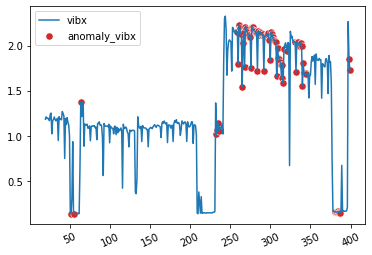

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly      vibz
64   4.053144        3.1     True  2.083871
233  3.898644        3.1     True -0.480654
234  3.849365        3.1     True -0.275772
235  4.160927        3.1     True -0.121420
236  3.954985        3.1     True -0.252659
237  3.819343        3.1     True  0.242511
238  3.469207        3.1     True -0.082579
239  3.394183        3.1     True -0.023441
240  3.270786        3.1     True -0.298001
255  3.674020        3.1     True -0.132958


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


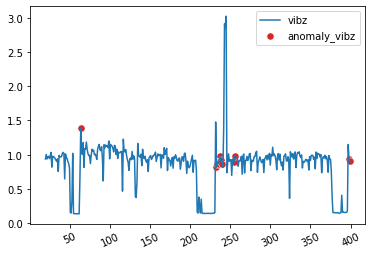

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly      temp
58   3.462230        3.1     True -3.274848
59   3.806441        3.1     True -3.836741
60   3.990327        3.1     True -4.265956
61   4.066899        3.1     True -4.598260
62   4.050082        3.1     True -4.861006
63   3.752478        3.1     True -4.821381
216  3.308393        3.1     True -3.332004
217  3.568188        3.1     True -3.898407
218  3.748808        3.1     True -4.265653
219  3.646370        3.1     True -4.510806


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


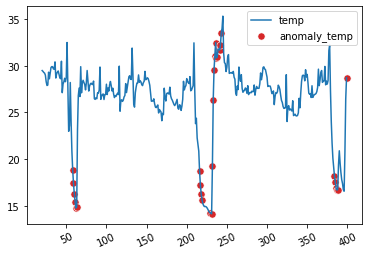

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly      zacc
52   3.421037        3.1     True -3.617905
64   3.481278        3.1     True  1.666277
67   4.772927        3.1     True  3.356645
210  3.195777        3.1     True -3.772210
222  3.392569        3.1     True -2.582749
223  3.544073        3.1     True -2.872798
224  3.456483        3.1     True -2.992956
225  3.517667        3.1     True -2.839901
226  3.529248        3.1     True -2.827023
227  3.402339        3.1     True -3.193855


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


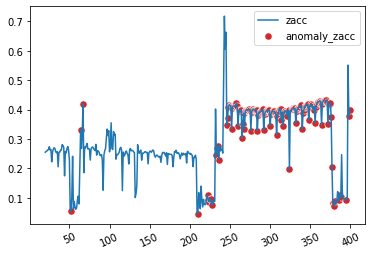

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly     crest
56   4.335821        3.1     True  4.794238
60   4.048035        3.1     True  5.080041
61   4.701918        3.1     True  6.162305
229  3.428566        3.1     True  4.309119
233  4.135698        3.1     True -0.509433
234  4.122151        3.1     True -0.492361
235  3.496086        3.1     True -0.444084
236  3.237278        3.1     True  0.449429
237  3.433875        3.1     True -0.381597
238  3.454575        3.1     True -0.564350


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


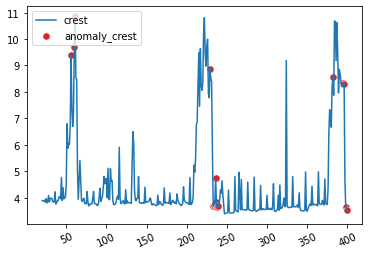

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


         loss  threshold  anomaly     zfreq
52   3.361129        3.1     True -3.447845
210  3.229293        3.1     True -3.447845
233  3.658379        3.1     True  0.231200
234  3.512455        3.1     True  0.705166
235  3.361861        3.1     True  0.579868
236  3.164148        3.1     True -0.618062
260  3.185709        3.1     True  1.972263
261  3.283212        3.1     True  3.180056
262  3.393251        3.1     True  3.284354
263  3.406795        3.1     True  3.306741


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


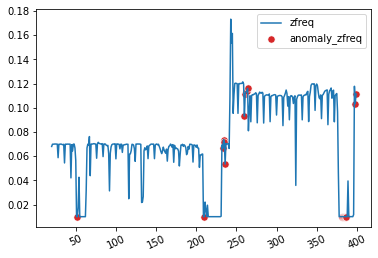

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
test_table=pd.DataFrame()
for colm in df.columns[1:7]:  
  anomalies,test,test_score_df,TIME_STEPS,col,scaler_anomaly_scaler= anomaly_test(df,col=colm,threshold=3.1)
  anomaly_plot(test,anomalies)
  test_table[col]=scaler_anomaly_scaler.inverse_transform(test[TIME_STEPS:][col])
  anomalies[col]=scaler_anomaly_scaler.inverse_transform(anomalies[col])
  anomalyy= anomalies.reset_index()
  anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
  total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)
  

In [82]:
total_anomalies.set_index("index",inplace=True)

In [84]:
total_anomalies[total_anomalies["anomaly"]==True]

,loss,threshold,anomaly,vibx,anomaly_count,vibz,temp,zacc,crest,zfreq
index,,,,,,,,,,
52,3.386281,3.1,True,-3.534243,1,NaN,NaN,NaN,NaN,NaN
55,3.129274,3.1,True,-3.544290,1,NaN,NaN,NaN,NaN,NaN
64,3.315009,3.1,True,1.308521,1,NaN,NaN,NaN,NaN,NaN
233,3.857403,3.1,True,-0.091629,1,NaN,NaN,NaN,NaN,NaN
234,3.767712,3.1,True,0.106375,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
385,3.561963,3.1,True,NaN,1,NaN,NaN,NaN,NaN,0.010056
386,3.596769,3.1,True,NaN,1,NaN,NaN,NaN,NaN,0.010000
387,3.329352,3.1,True,NaN,1,NaN,NaN,NaN,NaN,0.010000


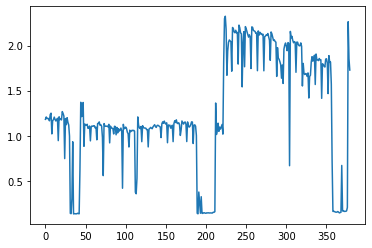

#Classification 

In [1]:
df = data.copy()

NameError: ignored

In [5]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [6]:
df["rul"]=[fail_time-i for i in df.index]

In [7]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)

for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

#label 2 // 48 hour

In [27]:

test_df=df.copy()
w0=48
w1=12
test_df["label1"]=np.where(test_df["rul"]< 0,0,0)
test_df["label2"]=np.where(test_df["rul"]< 0,0,0)
cols_normalize = test_df.columns.difference(['Time','rul',"label2","label1"])
pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/scaler_classification_label1.pkl", 'rb')
scaler_label_classification = pickle.load(pickle_in)
#Test


norm_test_df = pd.DataFrame(scaler_label_classification.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
# pick  window size 
sequence_length = 10

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]
# pick the feature columns 
sequence_cols=test_df.columns.difference(['Time','rul',"label2","label1"])

# generator for the sequences

seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape) 
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['label2'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)
model_path_label1 = "/content/drive/MyDrive/model_predictive_maintanence/classification_label1_model.h5"
model_path_label2 = "/content/drive/MyDrive/model_predictive_maintanence/classification_label2_model.h5"
estimator = load_model(model_path_label1)
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

classification_predicted_label2=[int(i) for i in y_pred_test]

(386, 10, 66)
(386, 1)
13/13 - 1s - loss: 8.7617e-09 - accuracy: 1.0000
Accurracy: 1.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#label 1 // 12 hour

In [28]:

test_df=df.copy()
w0=48
w1=12
test_df["label1"]=np.where(test_df["rul"]< 0,0,0)
test_df["label2"]=np.where(test_df["rul"]< 0,0,0)
cols_normalize = test_df.columns.difference(['Time','rul',"label2","label1"])
pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/scaler_classification_label1.pkl", 'rb')
scaler_label_classification = pickle.load(pickle_in)
#Test


norm_test_df = pd.DataFrame(scaler_label_classification.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
# pick  window size 
sequence_length = 10

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]
# pick the feature columns 
sequence_cols=test_df.columns.difference(['Time','rul',"label2","label1"])

# generator for the sequences

seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape) 
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['label1'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)
model_path_label1 = "/content/drive/MyDrive/model_predictive_maintanence/classification_label1_model.h5"
model_path_label2 = "/content/drive/MyDrive/model_predictive_maintanence/classification_label2_model.h5"
estimator = load_model(model_path_label2)
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

classification_predicted_label1=[int(i) for i in y_pred_test]

(386, 10, 66)
(386, 1)
13/13 - 1s - loss: 1.7403 - accuracy: 0.8834
Accurracy: 0.8834196925163269


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
